In [1]:

import torch
import torchvision.datasets as dsets
# torchvision.datasets 을 이용해 ImageNet 데이터셋을 관리
import torchvision.transforms as transforms
# MNIST등의 데이터셋에 들어있는 데이터들을 원하는 모양으로 변환할때 사용하는 모듈

from torch import FloatTensor
from torch import optim
# from torch import FloatTensor, optim 같이 한줄로 합쳐도 됨 (as로 새이름 정하지 않을경우)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# 학습 진행이 느려지면 자동으로 lr값을 조정해주는 module

from torch.utils.data import DataLoader
# 미니배치 데이터 로딩을 도울 모듈

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import json
# n01443537 같이 되어있는 클래스 이름들을 goldfish 와 같이 쉽게 바꿔줄 때 사용할 파일이 JSON파일
import os
# os.path.join(save_path, filename) 으로 파일 경로 합칠 때 사용
import shutil
# shutil.copyfile(path_a, path_b) a 경로의 파일을 b 경로에 복사

import scipy


import torchsummary
# 모델 구조 표로 정리해서 보여주는 모듈
# torchsummary.summary(model, input_size=(3, 224, 224), batch_size=64) 와 같이 사용

from torchvision import models
# pretrained 된 모델들을 담고 있는 모듈

import torchvision.transforms.functional as visionF
# 이미지 표시에 쓰이는 visionF.to_pil_image(img) 함수등 여러 함수 포함

from torchvision.utils import make_grid
# 이미지들을 표시할 grid 생성


import time
import datetime
# 시간 측정에 사용

import math

import copy
# copy.deepcopy()로 깊은 복사 수행

In [2]:
from BPfunctions import *

In [3]:
USE_CUDA = torch.cuda.is_available() 
# GPU 사용가능하면 True 반환

device = torch.device('cuda' if USE_CUDA else 'cpu')
print(f"==>> device: {device}")

==>> device: cuda


In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.247, 0.243, 0.262]),
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.247, 0.243, 0.262]),
])

# normalize 값 계산 : https://github.com/kuangliu/pytorch-cifar/issues/19

In [5]:
batch_size = 48

train_set = dsets.CIFAR10(root='../CIFAR10', train=True, download=True, transform=transform)
# train_set.data는 (50000, 32, 32, 3)꼴
# train_set.targets는 (50000,) 꼴

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set = dsets.CIFAR10(root='../CIFAR10', train=False, download=True, transform=val_transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Dualpath
class DualPathBP(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=1,
        bias=False,
        device="cpu",
        init_weights=True,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.kernel_size = kernel_size

        self.stride = stride
        self.padding = padding

        self.bias = bias

        self.device = device

        self.conv = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=2 * self.out_channels,
            groups=self.in_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            bias=self.bias,
            device=self.device,
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(
            -1, self.out_channels, 2, x.size(2), x.size(3)
        )
        # self.conv(x)의 size는 (batch_size, 2 * self.out_channels, output_size, output_size)
        # input channel 하나 마다 1x3x3 필터를 2개 적용해서 output channel 2개씩 생성

        # reshape로 (batch_size, self.out_channels, 2, output_size, output_size) 형태로 변경

        x = torch.sum(x, dim=2)
        # 각 input channel 별 2개씩 있던 output을 합쳐서
        # 각 input channel 마다 output channel 한개로 변경
        # (batch_size, self.out_channels, output_size, output_size) 형태

        return x
    
    def _initialize_weights(self):

        nn.init.kaiming_normal_(self.conv.weight, mode="fan_out", nonlinearity="relu")

        if self.conv.bias is not None:
            # batch normalization을 하고 있기때문에 conv는 bias를 따로 만들지 않아야한다.
            nn.init.constant_(self.conv.bias, 0)
            # nn.init.constant_(tensor, value) 는 주어진 tensor의 모든 entry들을 정해진 value값으로 바꿔준다

In [7]:
# block
class BPBlock(nn.Module):
    # Bottleneck 에서만 꼭 필요한 부분들도 미리 추가해두면
    # Bottleneck 코드 작성 시 편하다.
    expansion = 1
    # bottleneck 구조에서 쓰임

    def __init__(self, in_channels, out_channels, stride=1, device='cpu'):
        # 다른 block이랑 똑같게 groups는 인수에서 일단 뺌
        super().__init__()

        self.groups = 4
        # self.out_channels = out_channels
        self.out_channels = in_channels
        # output 채널의 개수를 conv로 늘리지 않고
        # x = torch.cat((x, x_shortcut), dim=1) 로 늘리기 때문에
        # in_channels로 변경

        self.device = device

        # BatchNorm 과정에서 bias를 추가하기 때문에 conv layer에서는 bias를 빼준다
        # https://stats.stackexchange.com/questions/482305/batch-normalization-and-the-need-for-bias-in-neural-networks

        self.DP1 = DualPathBP(in_channels=in_channels, out_channels=self.out_channels, kernel_size=3, stride=stride, device=self.device)
        self.BN1 = nn.BatchNorm2d(self.out_channels, device=self.device)

        self.PW = nn.Conv2d(            
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False, #PCNet과 동일하게 맞추기 위해 bias=False
            device=self.device)

        self.DP2 = DualPathBP(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, device=self.device)
        self.BN2 = nn.BatchNorm2d(self.out_channels, device=self.device)

        self.relu = nn.ReLU()

        self.shortcut = nn.Sequential()
        self.concat = False
        # identity mapping

        self.relu = nn.ReLU()

        # filter 갯수가 두배가 되는 블록인 경우에는 identity mapping 대신 1x1 conv로 projection 수행
        if stride != 1 or in_channels != BPBlock.expansion * out_channels:
            # @@@  이 조건문의 out_channels는 self.out_channels로 바꾸면 안된다.  @@@
            # in_channels != ResBlock.expansion * out_channels 은 각 층에서 제일 앞에 있는 블록에서만 참
            self.shortcut = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
            self.concat = True


    def forward(self, x):

        x_shortcut = self.shortcut(x)
        

        x = self.DP1(x)
        x = self.BN1(x)
        x = self.relu(x)
        

        x = self.PW(x)
        
        x = self.DP2(x)
        x = self.BN2(x)
        x = self.relu(x)


        if self.concat:
            x = torch.cat((x, x_shortcut), dim=1)
        else:
            x = x + x_shortcut


        x = self.relu(x)

        return x

In [8]:
# BPNet
class BPNet(nn.Module):
    def __init__(self, block_name, num_block_inlayers, num_classes=10, init_weights=True, device='cpu'):
        # block은 ResBlock 또는 Bottleneck 클래스 이름을 받아서 저장
        # num_block_inlayers 는 각 층마다 residual block이 몇개씩 들어가는지 정보를 담은 list
        super().__init__()

        self.in_channels = 32
        # 3x3 conv 지나면 32 채널이 됨

        self.device = device

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.in_channels, kernel_size=3, stride=1, padding=1, bias=False, device=self.device),
            # 3,32,32 를 받아서 32, 32, 32 로 변경
            nn.BatchNorm2d(self.in_channels, device=self.device),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # # 32, 32, 32 를 받아서 32, 16, 16 로 변경
        )

        self.conv2_x = self._make_layer(block_name=block_name, out_channels=32, num_blocks=num_block_inlayers[0], stride=1)
        self.conv3_x = self._make_layer(block_name=block_name, out_channels=64, num_blocks=num_block_inlayers[1], stride=1)
        self.conv4_x = self._make_layer(block_name=block_name, out_channels=128, num_blocks=num_block_inlayers[2], stride=2)
        self.conv5_x = self._make_layer(block_name=block_name, out_channels=256, num_blocks=num_block_inlayers[3], stride=2)
        # residual block들을 담은 4개의 층 생성

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        # filter 갯수는 유지하고 Width와 Height는 지정한 값으로 average pooling을 수행해 준다
        # ex: 256, 8, 8 을 256, 1, 1 로 변경

        self.fc = nn.Linear(in_features=256 * block_name.expansion, out_features=num_classes, device=self.device)

        if init_weights:
            self._initialize_weights()
            


    # residual block들을 지정된 갯수만큼 생성해 nn.Sequential() 안에 넣어서 반환해주는 함수
    def _make_layer(self, block_name, out_channels, num_blocks, stride):
        # block은 Resnet 클래스가 받아놓은 ResBlock 또는 Bottleneck 클래스 이름을 내려받음
        # 여기서의 out_channels은 residual block 안의 3x3 conv의 out_channels 갯수
        # num_blocks 는 이 층에 들어갈 residual block 갯수
        # stride는 이 층 제일 첫번째 residual block에서 down sampling을 할경우 1이 아닌 값을 넣어준다.
        
        strides = [stride] + [1] * (num_blocks - 1)
        # [stride, 1, 1, ...., 1] 꼴
        
        blocks = []
        # residual block들을 담을 list

        for stride in strides:
            blocks.append(block_name(in_channels=self.in_channels, out_channels=out_channels, stride=stride, device=self.device))
            # list 에 residual block 만들어서 저장

            self.in_channels = out_channels * block_name.expansion
            # residual block 생성 뒤에 코드가 있어서 
            # 한 층에서 다음 층으로 넘어가 만나는 첫 residual block에서 down sampling 하거나 
            # bottleneck 처럼 expansion이 4 인경우에도 문제없음

        return nn.Sequential(*blocks)
        # list 인 blocks 를 * 로 unpack해서 nn.Sequential()에 입력

    # 모델 안의 weights 초기화 함수
    def _initialize_weights(self):
        for m in self.modules():
            # self.modules() 은 모델 안에 들어있는 모든 module들(nn.Conv2d, nn.ReLu, nn.Linear 등)을 순회하는 iterator 
            
            if isinstance(m, nn.Conv2d):
                # isinstance(확인할 클래스 객체, 클래스이름) 으로 한 객체가 특정 클래스의 객체인지를 알 수 있다
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                # mode 의 'fan_in' 과 'fan_out' 에 대한 설명
                # fan_in은 여러번 forward 방향 계산을 반복할 때 weights 에 곱해서 얻어진 output에 활성함수를 적용할 때
                # 정해진 활성함수가 잘 작동하는 범위에 계속 있도록 weights 초기화를 하는 것이고
                # fan_out은 반대로 backprop 방향 계산을 반복할 때 활성함수의 미분이 잘 작동하는 범위에 계속 있도록 weights 초기화를 하는 것
                # so all in all it doesn't matter much but it's more about what you are after. 
                # I assume that if you suspect your backward pass might be more "chaotic" (greater variance) 
                # it is worth changing the mode to fan_out. This might happen when the loss oscillates a lot 
                # (e.g. very easy examples followed by very hard ones).

                # https://nittaku.tistory.com/269
                # https://stackoverflow.com/questions/61848635/how-to-decide-which-mode-to-use-for-kaiming-normal-initialization

                if m.bias is not None:
                    # batch normalization을 하고 있기때문에 conv는 bias를 따로 만들지 않아야한다.
                    nn.init.constant_(m.bias, 0)
                    # nn.init.constant_(tensor, value) 는 주어진 tensor의 모든 entry들을 정해진 value값으로 바꿔준다
            
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                # BatchNorm(x) = γx + β 에서
                # γ = 1, β = 0 으로 초기화
            
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                # mean 0, std 0.01인 정규분포로 초기화
                nn.init.constant_(m.bias, 0) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        # avg_pool까지 하면 [batch_size, 256 * expansion, 1, 1] 형태
        x = x.view(x.size(0), -1)
        # [batch_size, 256 * expansion] 꼴로 변경
        # x = torch.flatten(x, start_dim=1) 도 동일한 결과
        # # flatten에 start_dim=1을 넣어주면 dim=0 인 batch_size 부분은 그대로 두고 두번째부터 flatten 수행

        x = self.fc(x)

        return x

In [9]:
# def resnet18():
#     return ResNet(ResBlock, [2,2,2,2])

# def resnet34():
#     return ResNet(ResBlock, [3,4,6,3])

# def resnet50():
#     return ResNet(BottleNeck, [3,4,6,3])

# def resnet101():
#     return ResNet(BottleNeck, [3,4,23,3])

# def resnet152():
#     return ResNet(BottleNeck, [3,8,36,3])

def BPnet():
    return BPNet(BPBlock, [3,4,6,3], device=device)

In [10]:
model = BPnet()
# torchsummary.summary(model, (3,32,32), batch_size)

In [11]:
# https://otzslayer.github.io/pytorch/2022/04/10/loss-reduction-when-to-use-sum-mean-none-in-pytorch.html
# CrossEntropyLoss(reduction= ) 기본값: 'mean'
# batch_size = n 일 때 
# reduction = 'none' 이면 n개 각각의 loss를 알려주지만
# reduction = 'sum' 이면 ⁿ₁∑(ln) 을 반환하고
# reduction = 'mean' 이면 ⁿ₁∑(ln) / n 을 반환한다 ===> batch_size에 무관한 loss값을 얻을 때는 mean 사용

criterion = nn.CrossEntropyLoss(reduction='sum').to(device)
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# 학습 진행이 느려지면 자동으로 lr값을 조정해주는 module

lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)
# 5번동안 loss 변화가 없으면 lr = lr * factor 변경

In [12]:
# load_state(model=model, opt=opt, lr_scheduler=lr_scheduler, load_path='../CIFAR10/data/2023-08-30_epoch_39.pth')

# date_load_file = '2023-08-30'
# load_path = os.path.join("../CIFAR10/data/", f'{date_load_file}.json')
# loss_history, acc_history, time_history, total_num_epochs = load_history(load_path=load_path)


In [13]:
loss_history = {'train':[], 'val':[]}
acc_history = {'train_top1':[], 'val_top1':[], 'train_top5':[], 'val_top5':[]}
time_history = []
total_num_epochs = 0

In [14]:
params_train = {
    "num_epochs": 30,
    "optimizer": opt,
    "criterion": criterion,
    "train_loader": train_loader,
    "val_loader": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "save_path": "../CIFAR10/data/",
    "loss_history": loss_history,
    "acc_history": acc_history,
    "time_history": time_history,
    "total_num_epochs": total_num_epochs
}

In [15]:
trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-09-14 14:46:05
--------------------------------------------------
Epoch 0/29, current lr = 0.01
==>> len_data: 50000
train loss: 1.36867114, train accuracy: (top1: 50.58%, top5: 91.74%)
elapsed time: 0:00:43
==>> len_data: 10000
val loss: 1.0114758, val accuracy: (top1: 65.02%, top5: 96.90%)
elapsed time: 0:00:04
 epoch elapsed time = 0:00:47
==>> total_num_epochs: 1
--------------------------------------------------
Epoch 1/29, current lr = 0.01
==>> len_data: 50000
train loss: 0.792863325, train accuracy: (top1: 72.07%, top5: 98.04%)
elapsed time: 0:00:42
==>> len_data: 10000
val loss: 0.695014853, val accuracy: (top1: 76.03%, top5: 98.52%)
elapsed time: 0:00:04
 epoch elapsed time = 0:00:46
==>> total_num_epochs: 2
--------------------------------------------------
Epoch 2/29, current lr = 0.01
==>> len_data: 50000
train loss: 0.64863383, train accuracy: (top1: 77.51%, top5: 98.70%)
elapsed time: 0:00:42
==>> len_data: 10000
val loss: 0.74315195, val accuracy: (top1: 74.70%, to

In [17]:
# BPnet
# 256
# batch_size 48
# eps 0.00001
# momentum 0.1

# print(loss_hist)
# print(acc_hist)
# print(total_num_epochs)
# print(time_hist)

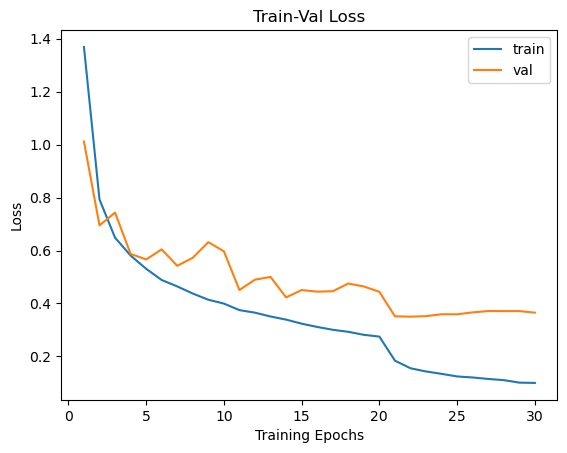

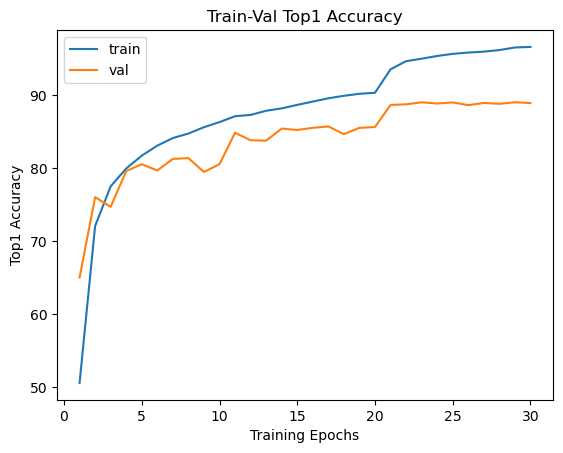

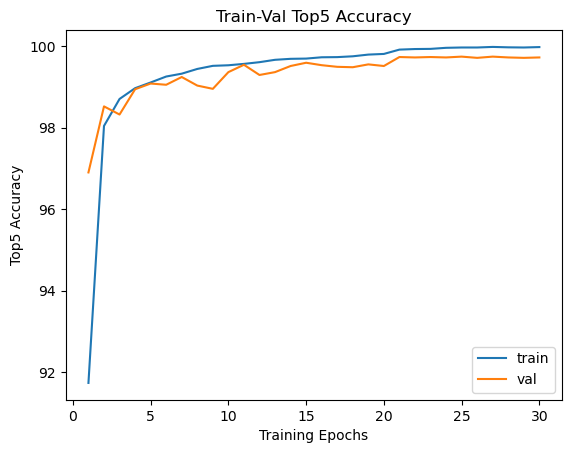

In [18]:
# BPnet
# 256
# batch_size 48
# eps 0.00001
# momentum 0.1

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()